# Customer Churn Analysis & Prediction

This notebook provides a comprehensive analysis of customer churn data, including exploratory data analysis (EDA), statistical testing, and predictive modeling using XGBoost.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Set plot style
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-pastel')

## 1. Data Loading & Overview

In [2]:
# Load the dataset
df = pd.read_csv('data/Customer-Churn.csv')

# Display first few rows
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Data Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# Convert TotalCharges to numeric (some empty strings need coercion)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

# Check for missing values again
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## 2. Exploratory Data Analysis (EDA)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33048\989657737.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='viridis')


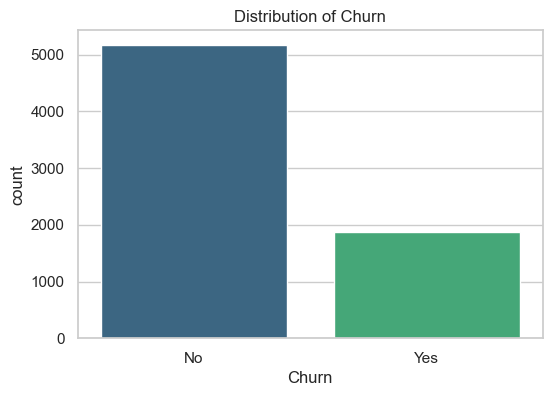

In [5]:
# Churn Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df, palette='viridis')
plt.title('Distribution of Churn')
plt.show()

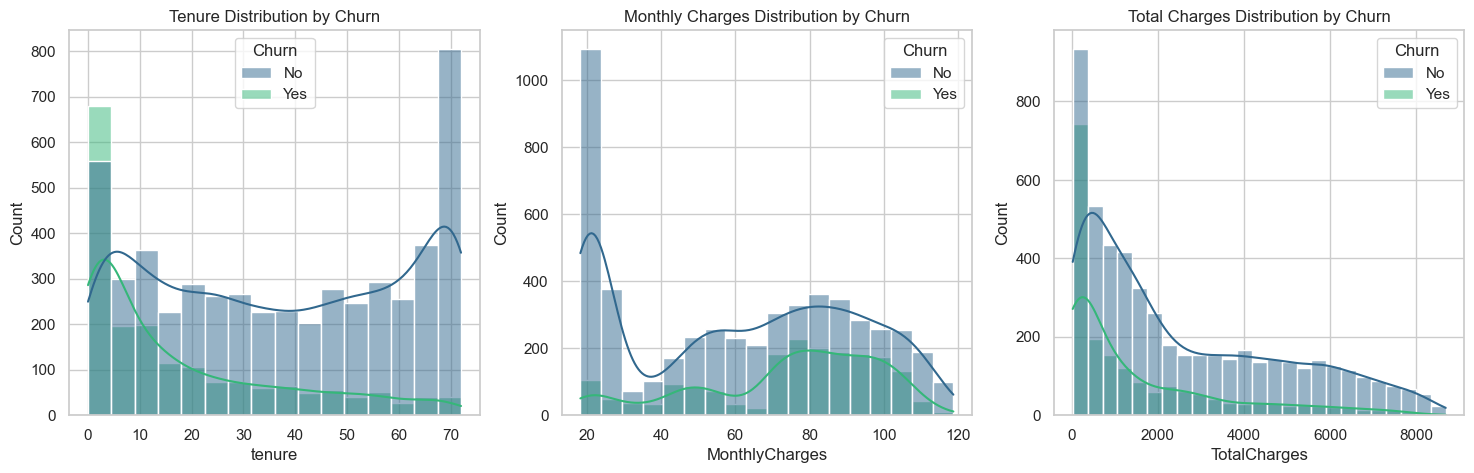

In [6]:
# Numerical Features Distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df, x='tenure', hue='Churn', kde=True, ax=axes[0], palette='viridis')
axes[0].set_title('Tenure Distribution by Churn')

sns.histplot(df, x='MonthlyCharges', hue='Churn', kde=True, ax=axes[1], palette='viridis')
axes[1].set_title('Monthly Charges Distribution by Churn')

sns.histplot(df, x='TotalCharges', hue='Churn', kde=True, ax=axes[2], palette='viridis')
axes[2].set_title('Total Charges Distribution by Churn')
plt.show()

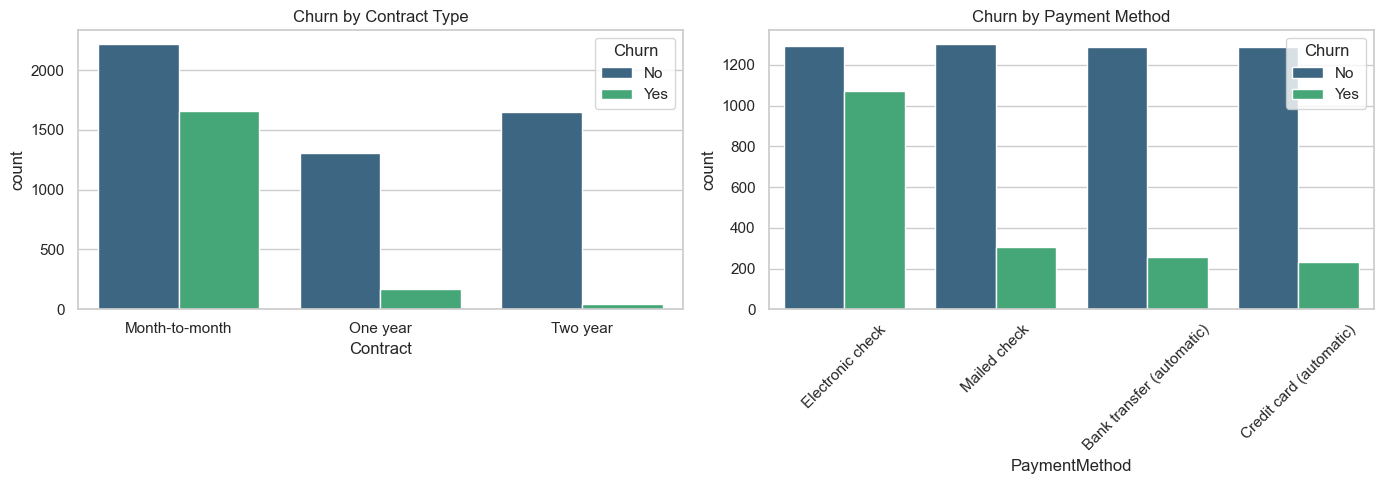

In [7]:
# Categorical Analysis: Contract & Payment Method
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x='Contract', hue='Churn', data=df, ax=axes[0], palette='viridis')
axes[0].set_title('Churn by Contract Type')

sns.countplot(x='PaymentMethod', hue='Churn', data=df, ax=axes[1], palette='viridis')
axes[1].set_title('Churn by Payment Method')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 3. Statistical Analysis

In [8]:
# Chi-square Test for Categorical Variables
cat_vars = ['SeniorCitizen', 'Partner', 'Dependents', 'Contract', 'PaymentMethod', 'PaperlessBilling', 'InternetService']

print("Chi-square Test Results:")
print("-" * 50)
for var in cat_vars:
    contingency = pd.crosstab(df[var], df['Churn'])
    chi2, p, _, _ = stats.chi2_contingency(contingency)
    print(f"{var:<20} p-value: {p:.4e} {'*' if p < 0.05 else ''}")

Chi-square Test Results:
--------------------------------------------------
SeniorCitizen        p-value: 1.5101e-36 *
Partner              p-value: 2.1399e-36 *
Dependents           p-value: 4.9249e-43 *
Contract             p-value: 5.8630e-258 *
PaymentMethod        p-value: 3.6824e-140 *
PaperlessBilling     p-value: 4.0734e-58 *
InternetService      p-value: 9.5718e-160 *


In [9]:
# Mann-Whitney U Test for Numerical Variables
num_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']

print("\nMann-Whitney U Test Results:")
print("-" * 50)
for var in num_vars:
    churned = df[df['Churn']=='Yes'][var]
    stayed = df[df['Churn']=='No'][var]
    _, p = stats.mannwhitneyu(churned, stayed)
    print(f"{var:<20} p-value: {p:.4e} {'*' if p < 0.05 else ''}")


Mann-Whitney U Test Results:
--------------------------------------------------
tenure               p-value: 2.4196e-208 *
MonthlyCharges       p-value: 3.3116e-54 *
TotalCharges         p-value: 1.0853e-84 *


## 4. Modeling (XGBoost)

In [10]:
# 1. Drop unnecessary columns
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

# 2. Encode Target Variable
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3. One-hot Encoding
df_encoded = pd.get_dummies(df, drop_first=True)

# 4. Split Data
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Set: {X_train.shape}")
print(f"Testing Set: {X_test.shape}")

Training Set: (5634, 30)
Testing Set: (1409, 30)


In [11]:
# Train Model
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,None
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_meth

In [12]:
# Evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8126

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1036
           1       0.68      0.56      0.61       373

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.80      0.81      0.81      1409



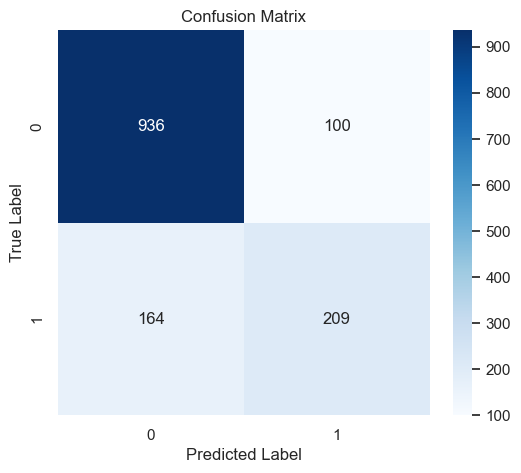

In [13]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

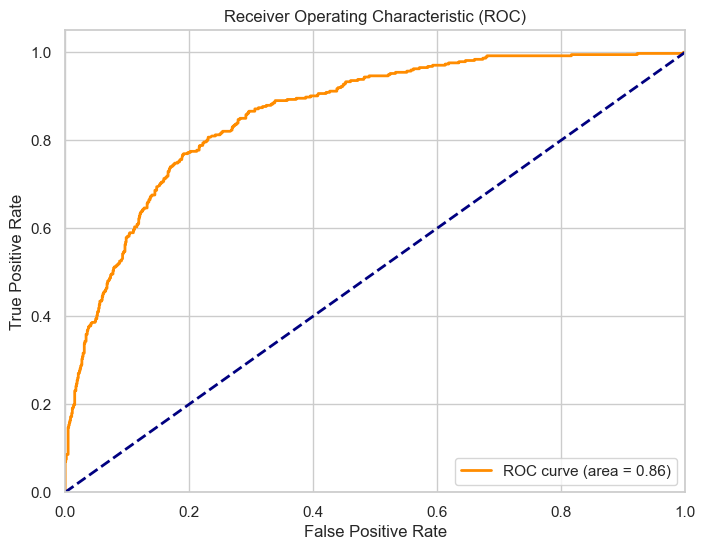

In [14]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## 5. Feature Importance

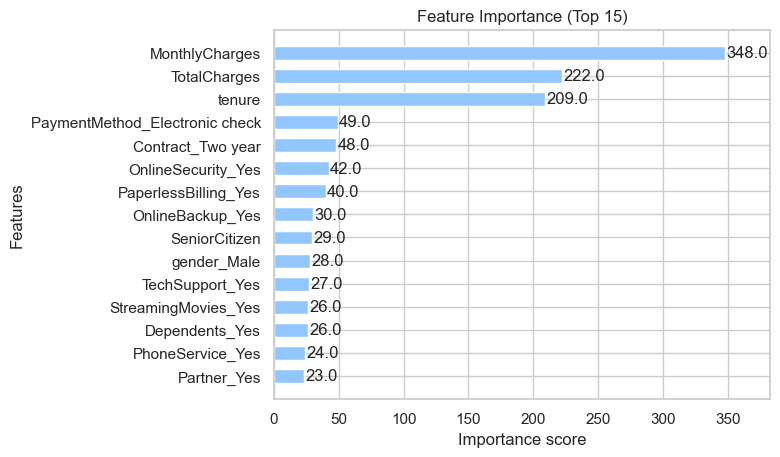

In [15]:
# Plot Feature Importance
xgb.plot_importance(model, max_num_features=15, height=0.6)
plt.title('Feature Importance (Top 15)')
plt.show()